<a href="https://www.kaggle.com/code/unifey/excess-mortality-rok?scriptVersionId=93125798" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Excess Mortality in the Republic of Korea since COVID19

## Introduction

This notebook investigates excess mortality in the Republic of Korea since the spread of COVID19 in 2020. To that end, we build a model for expected mortality based on the prior 5 years (2015-2019) of mortality data.

## Preparation

In [1]:
#--------- Import moduels we will use

import math
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np

import datetime as dt
from datetime import datetime
from datetime import timedelta

import seaborn as sns
sns.set(style="dark"
        #, context="talk" # `context="talk"` renders plot elements suitable for giving talks
        , font_scale=0.8) 
import pylab as plt
import matplotlib.transforms as transforms

import requests # For API request
import urllib # For parsing URLs properly
import xml.etree.ElementTree as ET # For parsing XML

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib.font_manager as fm
rot = 90 # Angle for label rotation

#--- Modules for linear modeling

from scipy.optimize import leastsq
from scipy import stats # For normal qqplot

import statsmodels.api as sm
from statsmodels.formula.api import glm

from IPython.display import display, Markdown
def dmd(string):
    display(Markdown(string))

## Mortality Data for ROK

* Mortality data for 2019 and before was obtained at https://mdis.kostat.go.kr/index.do
* Mortality since 2020 was obtained at https://kosis.kr/covid/statistics_excessdeath.do
* Because the above sites provide data in Excel sheets, we have collected them in CSV files at https://www.kaggle.com/datasets/unifey/weekly-mortality-republic-of-korea/


In [2]:
#--------- Create mortality dataframe

years = ['2015','2016','2017','2018','2019','2020','2021']
columns = []
files = []

df_list = list()

for year in years:
    file = "_".join(['../input/weekly-mortality-republic-of-korea/mortality'
                     ,year,'korea.csv'])
    data = pd.read_csv(file)
    df_list.append(data)

df = pd.concat(df_list)

#--- Set appropriate data types
df = df.astype(int,errors='ignore')
df.end_date = pd.to_datetime(df.end_date, format = '%Y-%m-%d')

#--- Organize dataframe
df.set_index('end_date', inplace=True)
df.dropna(inplace=True, axis=0)
df = df.rename(columns={'mortality':'total_mortality'})

df['under65'] = df['0-14']+df['15-64']
df['over65'] = df['65-74']+df['75-84']+df['85+']

#--- Add "week" parameter `t` that begins from 2015
N_t = len(df.index) # Number of weeks in dataframe
tvals = np.linspace(0,N_t-1,N_t)
df['t'] = tvals
dmd('`df`: Weekly Mortality in Republic of Korea')
dmd('Last 5 records of `df`:')
df.tail()

`df`: Weekly Mortality in Republic of Korea

Last 5 records of `df`:

,week,total_mortality,0-14,15-64,65-74,75-84,85+,under65,over65,t
end_date,,,,,,,,,,
2021-12-04,48,6884,20,1300,1138,2101,2325,1320,5564,360.0
2021-12-11,49,6987,23,1275,1098,2211,2379,1298,5688,361.0
2021-12-18,50,7122,15,1328,1195,2237,2347,1343,5779,362.0
2021-12-25,51,7075,22,1305,1169,2225,2354,1327,5748,363.0
2022-01-01,52,6886,24,1308,1088,2094,2372,1332,5554,364.0


## Model for Expected Mortality and Excess Mortality

We build a generalized linear model (named `model`) for expected mortality based on the data from 2015 to 2019. The model is of the following form:
$$ \text{expected_mortality}(t) = \beta_0 + \beta_1 t + \beta_2\sin(2\pi t/T) + \beta_3 \cos(2\pi t/T), $$
where $T$ equals the week-year, that is, $365.25 \, \text{days/year})/(7 \,\text{days/week})$. The linear term is for changes in popluation distribution, and the sinusoidal terms for seasonal effects. The excess mortality is then defined by
$$ \text{excess_mortality} = \text{actual_mortality} - \text{expected_mortality}. $$

In [3]:
#--------- Build model
age_groups = [ 'total_mortality', '0-14', '15-64', '65-74', '75-84', '85+', 'under65', 'over65']
r2_list = list()
rmse_list = list()

for ylabel in age_groups:

    ypred = ylabel+'^'
    
    #--- Prepare traning dataset
    
    data = df.loc['2010':'2019']

    #--- Build the model
    
    data = data.rename(columns={ylabel:'y'})

    weekyear = 365.25/7

    T = weekyear / (2*math.pi)

    formula = 'y ~ t + np.sin(t/T) + np.cos(t/T)'

    model = glm(formula = formula
                , data = data
                , family = sm.families.Poisson())
    
    model = model.fit()

    data[ypred] = model.fittedvalues

    #--- Compute the expected mortality

    tvals = df.t
    
    yhat = model.predict(exog=dict(t=tvals))
    
    df[ypred] = yhat
    
    #--- Compute the excess mortality
    yres = ylabel + '_res'
    df[yres] = df[ylabel] - df[ypred]
    df['null'] = 0
    data[yres] = data['y'] - data[ypred]
    data['null'] = 0
    
    #--- Compute the RMSE
    rmse = data[yres].std()
    rmse_list.append(rmse)
    
    #--- Compute the residual z-scores
    yres_z = ylabel + '_res_z'    
    df[yres_z] = df[yres]/rmse
    
    #--- Compute R^2:
    std = data.y.std()
    r2 = 1 - (rmse/std)
    r2_list.append(round(r2,2))

#--- Dataframe for R^2
dr2 = pd.DataFrame(
    {'age_group':age_groups
     ,'R^2':r2_list
    }).set_index('age_group')

#--- Dataframe for RMSE
drmse = pd.DataFrame(
    {'age_group':age_groups
     ,'rmse':rmse_list
    }).set_index('age_group')

## Visualization of Excess Mortality

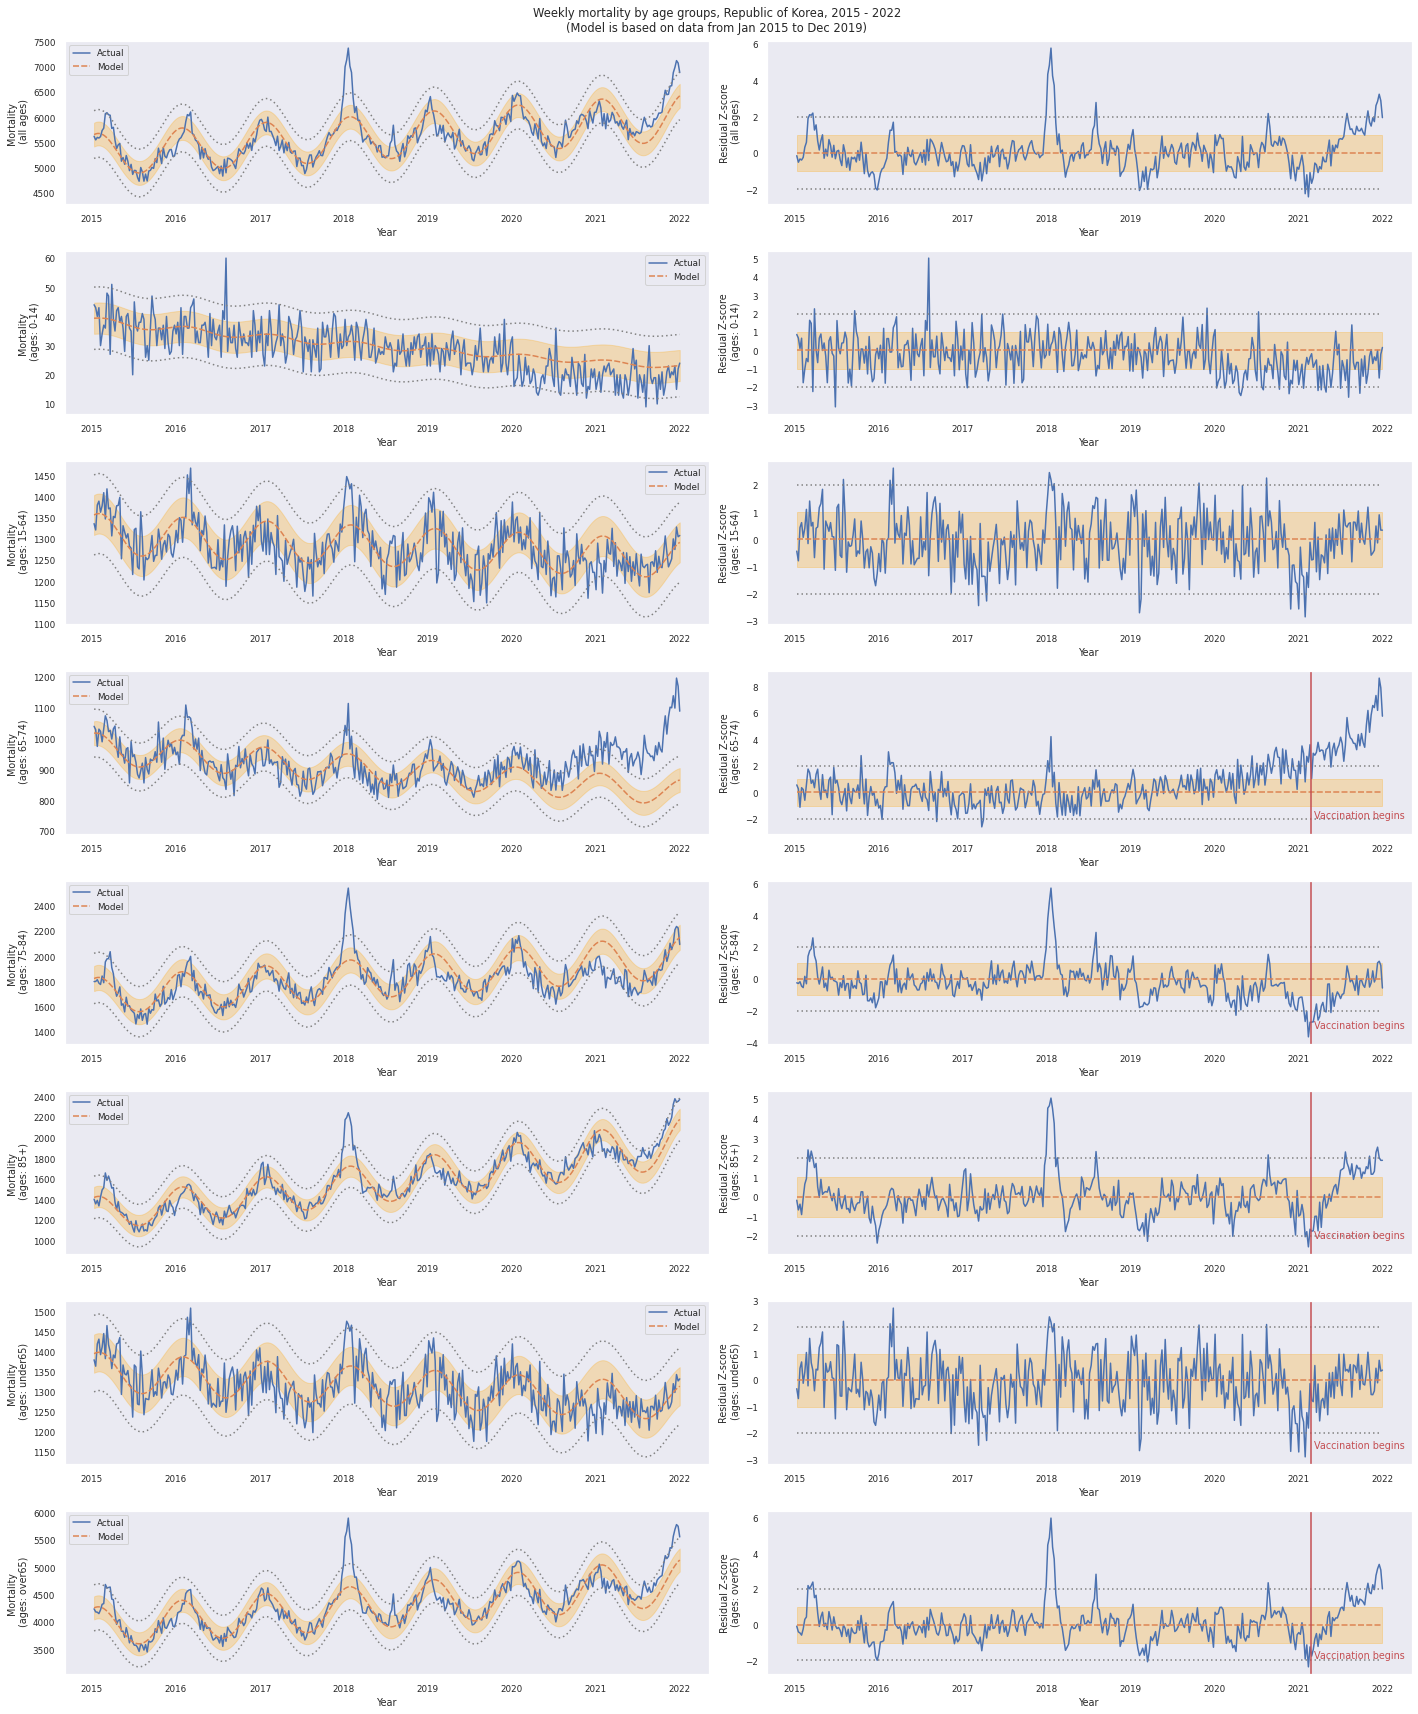

### $R^2$ for each age group

,R^2
age_group,
total_mortality,0.42
0-14,0.17
15-64,0.21
65-74,0.36
75-84,0.37
85+,0.50
under65,0.22
over65,0.44


In [4]:
# Slice dataframe with 2020 data

data = df

# t values since COVID vaccination
t_vax = df.loc['2021-02-27','t']

#--------- Create subplots

fig, axes = plt.subplots(nrows = len(age_groups)
                         , ncols = 2
                         , sharex = False
                         , figsize = (20, 3*len(age_groups))
                        )

for y_k, ylabel in enumerate(age_groups):
    
    ypred = ylabel+'^'# Expected mortality
    yresz = ylabel+'_res_z' # Residual Z-score of excess mortality

    x_value = data.index
    y_value = data[ypred]

    bandwidth = drmse.at[ylabel,'rmse'] # Width of RMSE

    alpha=0.25
    dash = (1,2)
    
    #--- Left column (Actual mortality)
    ax1 = axes[y_k,0]
    ax1.set(ylabel = 'Mortality')
    
    # Actual mortality and baseline
    sns.lineplot(data = data[[ylabel,ypred]]
                 , ax = ax1
                )
    
    # Band for |Z|=1
    ax1.fill_between(x_value, y_value+bandwidth, y_value-bandwidth, alpha=alpha, color = 'orange')
    
    # Upper threshold (Z=2)
    sns.lineplot(x = x_value
                 , y= y_value+2*bandwidth
                 , style = True
                 , dashes=[dash]
                 , color = 'gray'
                 , ax = ax1)
    # Lower threshold (Z=-2)
    sns.lineplot(x = x_value
                 , y= y_value-2*bandwidth
                 , style = True
                 , dashes=[dash]
                 , color = 'gray'
                 , ax = ax1)

    ax1.legend(['Actual','Model'])    

    if y_k == 0:
        ax1.set_ylabel("Mortality\n (all ages)")
    else:
        ax1.set_ylabel("Mortality\n (ages: "+ylabel+")")
    
    ax1.set_xlabel('Year')
    
    #--- Right column (Residual plot)
    
    ax2 = axes[y_k,1]

    # Excess mortality and baseline
    sns.lineplot(data = data[[yresz,'null']]
                       , ax = ax2
                )
    
    z_value = data.null
    
    bandwidth_z = 1
    
    # Band for |Z|=1
    ax2.fill_between(x_value
                     , z_value+bandwidth_z
                     , z_value-bandwidth_z
                     , alpha=alpha, color = 'orange')

    # Upper threshold (Z=2)
    sns.lineplot(x = x_value
                 , y= z_value+2*bandwidth_z
                 , style = True
                 , dashes=[dash]
                 , color = 'gray'
                 , ax = ax2)
    
    # Lower threshold (Z=-2)
    sns.lineplot(x = x_value
                 , y= z_value-2*bandwidth_z
                 , style = True
                 , dashes=[dash]
                 , color = 'gray'
                 , ax = ax2)
    
    #--- Indicate the beginning of COVID vaccination

    if y_k > 2:
        
        # The following transformation allows us to use
        # data-coordinates for x-coordinates and axes-coordinates for y-coordinates
        trans = transforms.blended_transform_factory(
            ax2.transData, ax2.transAxes)
        
        anno = ' Vaccination begins'

        ax2.text(datetime(2021,2,26), 0.1
             , anno, ha = 'left'
             , color = 'r'
             , transform=trans)
        
        ax2.axvline(x=datetime(2021,2,26), 
                   ymin=0, ymax=1, color='r')

    ax2.get_legend().remove()

    if y_k == 0:
        ax2.set_ylabel("Residual Z-score\n (all ages)")
    else:
        ax2.set_ylabel("Residual Z-score\n (ages: "+ylabel+")")

    ax2.set_xlabel('Year')


suptitle = 'Weekly mortality by age groups, Republic of Korea, 2015 - 2022'
suptitle = suptitle+'\n(Model is based on data from Jan 2015 to Dec 2019)'
figfile = 'mortality_rok_en.png'

plt.suptitle(suptitle
             , y = 0.99)

plt.tight_layout()
plt.savefig(figfile, dpi=150)
plt.show()

dmd('### $R^2$ for each age group')
display(dr2)

## Comments

1. Accommodating actual age distribution in place of the linear term might improve the model, but data is lacking as far as I know.
2. To increase $R^2$, we could consider daily features such as weather.
3. The increasing tendency since COVID vaccination in the 65+ age group is in want of an explanation.

# Correlation between excess mortality and vaccination in the 65+ age group

We restrict our attention to the 65+ age group and examine the correlation between the excess mortality rate and:

* vaccination rate 
* 7-day average number of daily vaccine administrations

If there is a causal relation between the experimental COVID vaccine and excess mortality, we expect some time delay in that relation. Here we assume that delay to be 30 days.

In [5]:
# The assumed time delay in the possible causal relation between vaccination and excess death:
delay = -30

# Import COVID vaccination data
url_vax = 'https://github.com/owid/covid-19-data/raw/master/public/data/vaccinations/vaccinations.csv'
dv = pd.read_csv(url_vax, on_bad_lines='warn')
dv = dv[dv.location == 'South Korea']

# Select columns from vaccination data
cols = ['date', 'people_vaccinated_per_hundred', 'daily_vaccinations']
dv = dv[cols]
dv.columns = ['date','vax_rate','daily_vax']
dv.date = pd.to_datetime(dv.date)
dv.set_index('date',inplace=True)

# Shift the vaccination data by `delay` amount of days
dv = dv.shift(periods=delay)

# Join with mortality data
dg = df[['over65_res_z']].join(dv, how='inner')


## Visualization

### Correlations

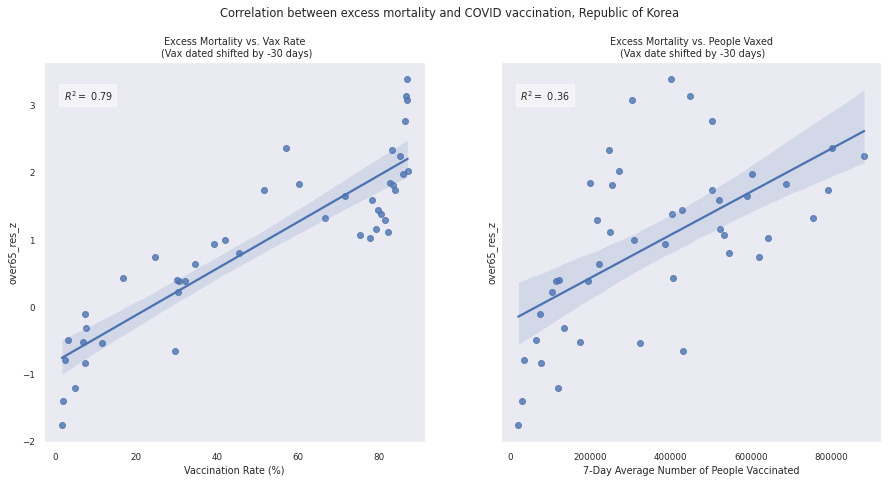

In [6]:
fig, axes = plt.subplots(nrows = 1
                         , ncols = 2
                         , sharex = False
                         , sharey = True
                         , figsize = (15,7)
                        )

cols = ['vax_rate','daily_vax']
xlbs = ['Vaccination Rate (%)','7-Day Average Number of People Vaccinated']
ttls = ['Excess Mortality vs. Vax Rate\n (Vax dated shifted by -30 days)'
       ,'Excess Mortality vs. People Vaxed\n (Vax date shifted by -30 days)']

for k,(col,xlabel, title) in enumerate(zip(cols,xlbs,ttls)):

    ax = axes[k]

    sns.regplot(data=dg, y='over65_res_z', x=col, ax=ax)
    
    anno = '$R^2 = $ '+str(round(dg.corr().at['over65_res_z',col]**2,2))
    ax.text(x=0.05, y=0.9, s = anno, ha = 'left', transform=ax.transAxes 
           , bbox=dict(facecolor='w', alpha=0.5))
    ax.set_xlabel(xlabel)
    ax.set_title(title)

suptitle = 'Correlation between excess mortality and COVID vaccination, Republic of Korea'
plt.suptitle(suptitle
             , y = 0.99)
plt.savefig('excess_mortality_vs_vax_correlations.png', dpi=150)

plt.show()

### Time evolutions

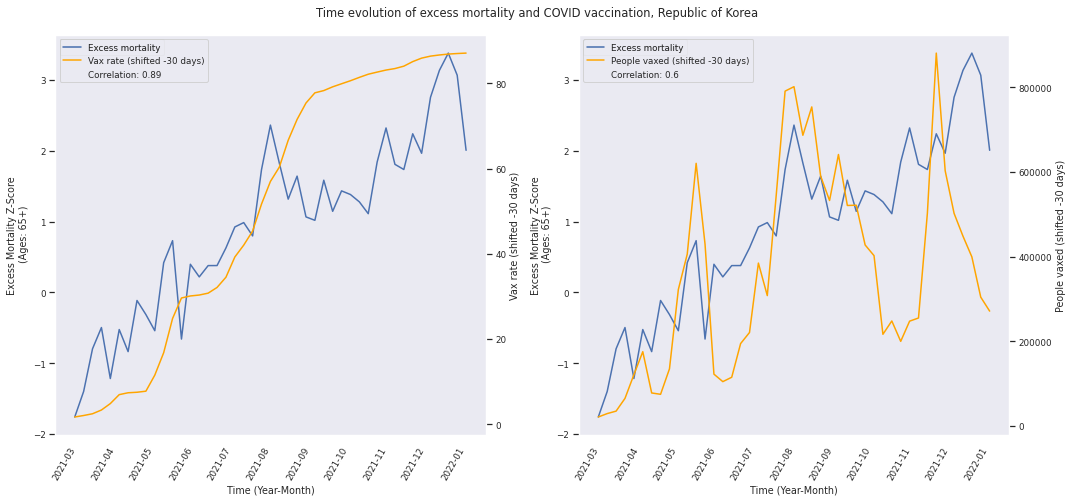

In [7]:
fig, axes = plt.subplots(nrows = 1
                         , ncols = 2
                         , sharex = False
                         , sharey = False
                         , figsize = (15,7)
                        )

cols = ['vax_rate','daily_vax']
ylbs = ['Vaccination Rate (%)','7-Day Average Number of People Vaccinated']
txts = ['Vax rate (shifted -30 days)','People vaxed (shifted -30 days)']

for k,(col, ylb, txt) in enumerate(zip(cols, ylbs, txts)):
    
    ax = axes[k]
    
    sns.lineplot(x=dg.index, y=dg['over65_res_z'], ax=ax, label = 'Excess mortality')
    
    fig.autofmt_xdate(rotation=60)
    
    ax.set_xlabel('Time (Year-Month)')
    ax.set_ylabel('Excess Mortality Z-Score\n (Ages: 65+)')

    ax2 = ax.twinx()
    sns.lineplot(x=dg.index,y=dg[col], ax=ax2, color='orange', label = txt)
    ax2.set_ylabel(txt)

    anno = 'Correlation: '+str(round(dg.corr().at['over65_res_z',col],2))
    ax2.plot([], [], ' ', label=anno)

    ln, lb = ax.get_legend_handles_labels()
    ln2, lb2 = ax2.get_legend_handles_labels()
    ax2.legend(ln + ln2, lb + lb2, loc=0)

    #ax2.text(0.7, 0.1, anno, ha = 'left', transform=ax.transAxes)

suptitle = 'Time evolution of excess mortality and COVID vaccination, Republic of Korea'
plt.suptitle(suptitle
             , y = 0.99)
plt.tight_layout()
plt.savefig('excess_mortality_vs_vax_evolutions.png', dpi=150)

plt.show()
